In [2]:
# Python 3.10.8

#https://nbviewer.org/github/SHTOOLS/SHTOOLS/blob/master/examples/notebooks/grids-and-coefficients.ipynb
import numpy as np 
import matplotlib.pyplot as plt 
from time import time 
import ot

from geomstats.geometry.hypersphere import Hypersphere
import geomstats.visualization as visualization

import functions



# Comparison between regularized and unregularized contours

In [3]:
# 1) sample 
n_samples = 2001 
dataA = Hypersphere(dim=2).random_von_mises_fisher(mu=np.array([0,-0.5,np.sqrt(0.75)]),kappa=20, n_samples=int(n_samples*0.3))
dataB = Hypersphere(dim=2).random_von_mises_fisher(mu=np.array([0,0.5,np.sqrt(0.75)]),kappa=20, n_samples=n_samples-int(n_samples*0.3))
data = np.concatenate([dataA,dataB])

#data = Hypersphere(dim=2).random_von_mises_fisher(mu=np.array([0,-0.5,np.sqrt(0.75)]),kappa=20, n_samples=n_samples)

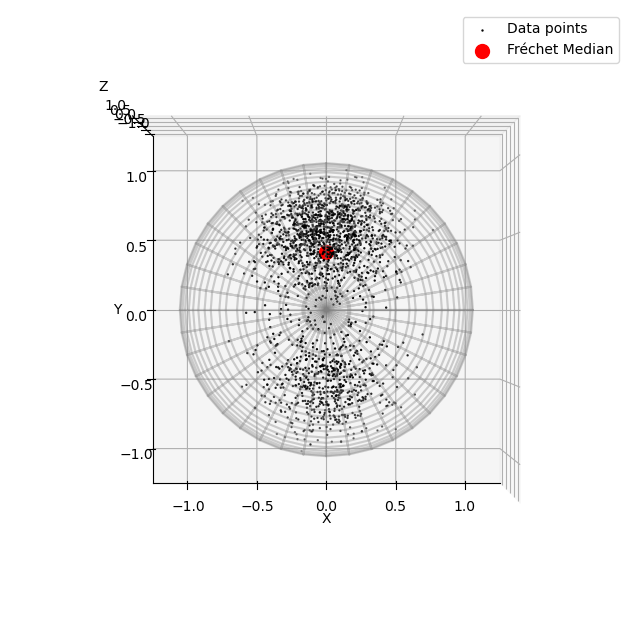

In [4]:
MeanData = functions.func_GeomMedian(data) 

fig = plt.figure(figsize=(8, 8)) 
ax = visualization.plot(data, space="S2", color="black", s=0.5, label="Data points")
ax = visualization.plot(MeanData.reshape(1,3), space="S2", color="red",alpha=1,s=100, label="Fréchet Median",)
ax.set_box_aspect([1, 1, 1]) 
ax.legend()
el = 90
az = 275
ax.view_init(el,az)

# 1) Solving OT problem

After defining required functions, we solve the OT problem between the data and the uniform on the sphere.

In the next cell, key parameters are the regularization `eps`, and the number of epochs for gradient descent, that performs `epoch*n` iterations for `n` observations in the data. 

The first thing to do in case of any bug is to take a bigger `epoch` to increase the number of iterations.

Through the dual potential, one can estimate the Wasserstein distance. Plotting this estimate with respect to the iterations indicates on the convergence of the algorithm.

SGD time: 1.1954777359962463 minutes


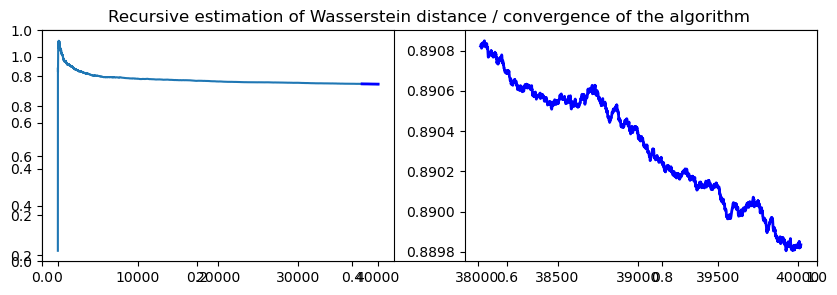

In [5]:
eps = 0.01 # regularization parameter
N_epoch = 20

# Robbins-Monro / Stochastic gradient descent 
t = time()
u,hat_W = functions.Robbins_Monro_Algo(Y=data, eps=eps, gamma= 1, c = 0.51, epoch = N_epoch,l_max=30)
t2 = time()
print("SGD time: {} minutes".format((t2-t)/60))

n_iter = len(data)*N_epoch
plt.figure(figsize=(10,3))
plt.title("Recursive estimation of Wasserstein distance / convergence of the algorithm")
plt.subplot(1,2,1)
plt.plot(np.arange(n_iter),hat_W)
n_start = len(data)*(N_epoch-1)
plt.plot(np.arange(n_start,n_iter),hat_W[n_start:],'b',linewidth=2)

plt.subplot(1,2,2)
plt.plot(np.arange(n_start,n_iter),hat_W[n_start:],'b',linewidth=2)

The resulting object is a Kantorovich dual potential from which the Monge mapping is defined. 
It can be visualized as follows, with blue areas being the lowest values, and red areas being the highest values.

Text(0.5, 1.0, 'Kantorovich dual potential')

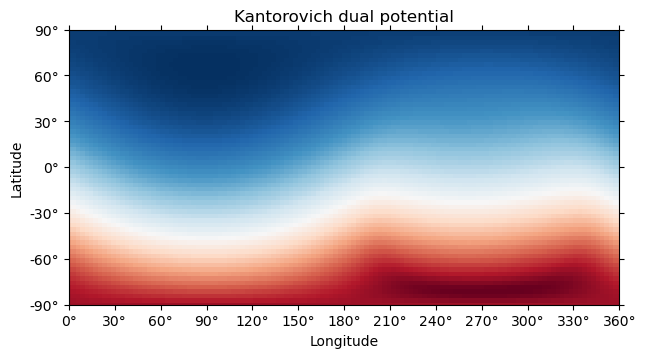

In [6]:
fig, ax = u.plot(cmap='RdBu',
                    cmap_reverse=True,
                    show=False)
plt.title("Kantorovich dual potential")

This Kantorovich dual potential can be compared with the data, to verify its coherence. 

As in the euclidean case, the inverse of the gradient $(-\nabla \psi)$ of the convex function $u$ at $x$ is directed to minimizers of $u$. Thus, at any point $x$ in the figure above, it shall be directed towards areas **more blue**.
But differentiation of the Kantorovich potential gives the Monge map $Q$ from the uniform distribution on the sphere to the data points, and we expect the images $Q(x) \in \mathbb{S}^{2}$ to cover the data points. 

Consequently, **data is expected to lie in the blue areas of the figure above**.
The following figure shows that this is indeed the case.
In addition to the data points in green and the Fréchet Median in red, a colormap illustrates the squared Riemannian distance $c(x,m)$, with respect to the Fréchet Median $m$, of every point $x$ in the sphere.


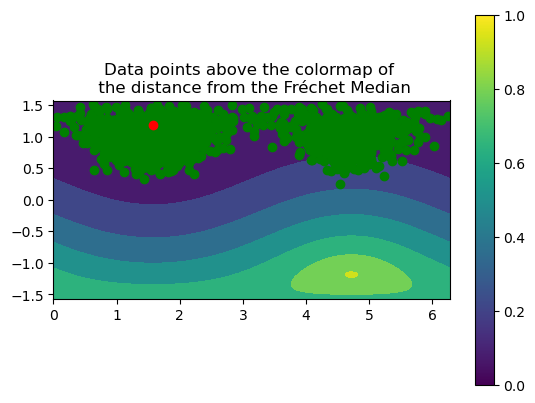

In [7]:
v_lat = u.lats()*np.pi/180 #from degrees to radians
v_lon = u.lons()*np.pi/180 

C = functions.cost_fft2(u,MeanData)
h = plt.contourf(v_lon, v_lat, C)
yc = functions.cartesian2polar(data.T)
plt.scatter(yc[0],yc[1],color='green')
yc = functions.cartesian2polar(MeanData)
plt.scatter(yc[0],yc[1],color='red')
plt.axis('scaled')
plt.title("Data points above the colormap of \n the distance from the Fréchet Median")
plt.colorbar()
plt.show()

# 2) Computing the central point for reference contours

In [8]:

F_thetaM = functions.Fentropic2(MeanData,u,eps)

For the discrete-discrete OT problem, we use a regular grid that decomposes the `n` observations into `nR*nS+n0`, with `n0` points at the central point `F_thetaM`, `nR` radius and `nS` directions in the equator. 

In [9]:

def contours_discrete(data,ranks,nS,nR,F_thetaM):
    # regular grid
    n = data.shape[0]
    n0 = n % nS
    regularGrid = []
    for i in range(1,nR+1):
        tau = i / (nR+1)
        points = functions.contour_unif_rotated(F_thetaM,tau,size=nS)
        regularGrid.append(points)
    regularGrid = np.array(regularGrid).reshape(nR*nS,3)
    if (n0>0):
        regularGrid = np.append(regularGrid,np.array([F_thetaM]*n0),axis=0)
    # simplex algorithm
    a = np.ones(n)/n
    C = -np.eye(n)
    for i in range(n):
        for j in range(n):
            x = regularGrid[i]
            y = data[j]
            C[i,j] = 0.5*np.arccos( np.dot(x,y) )**2 
    T = ot.emd(a,a,C)

    # contours
    res = []
    for rank in ranks:
        contour_discret = []
        for j in range(nS):
            contour_discret.append( data[np.where(T[rank*nS + j]>0)][0] )
        res.append(contour_discret )

    res = np.array(res)
    return(res)


rayons = [0.1,0.25,0.5,0.75,0.9]
nR = 40
nS = 50
ranks = [10,20,31]
rayons = np.array(ranks)/(nR+1)
print(rayons)

contours_dis = contours_discrete(data,ranks=ranks,nS=nS,nR=nR,F_thetaM=F_thetaM)


[0.24390244 0.48780488 0.75609756]


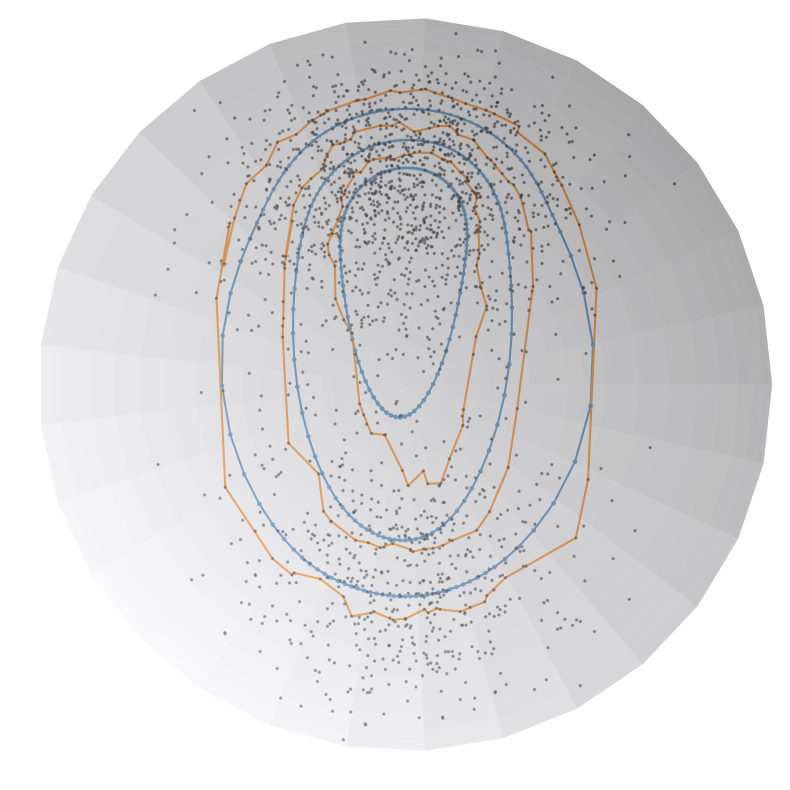

In [10]:

plt.figure(figsize=(10,10))
ax = functions.def_ax_sphere3D(el,az,sph_alpha=0.3)
functions.plot_3d_scatter(data ,ax,colour="black",sz=2,alpha=0.5)

for i,tau in enumerate(rayons):
    # Regularized : 
    points = functions.contour_unif_rotated(F_thetaM,tau,size=100)
    df = functions.QentropicBP_pts(points,u,data,eps)
    #df = QentropicBP_pts(points,u,data,eps)
    ax.plot(df[:,0],df[:,1],df[:,2],c= '#377eb8')
    ax.scatter(df[:,0],df[:,1],df[:,2],c= '#377eb8',s=5)
    # Unregularized : 
    df = contours_dis[i]
    ax.plot(df[:,0],df[:,1],df[:,2],c= '#ff7f00')
    df = df[[len(df)-1,0],:]
    ax.plot(df[:,0],df[:,1],df[:,2],c= '#ff7f00')
    ax.scatter(df[:,0],df[:,1],df[:,2],c= '#ff7f00',s=25,marker="+")


# 2) Comparison with ground truth

In [15]:
kappa = 20
mu = np.array([0,0,1])
n_samples = 2001 
data = Hypersphere(dim=2).random_von_mises_fisher(mu=mu,kappa=kappa, n_samples=n_samples)
MeanData = functions.func_GeomMedian(data)

# Functions for ground truth contours : 
def inv_Ff_star(b,kappa):
    toto = (b+1)/2 * (np.exp(kappa)- np.exp(-kappa)) + np.exp(-kappa)
    toto = np.log(toto) / kappa
    return(toto)

def Ff_star(a,kappa):
    toto = (np.exp(a * kappa)- np.exp(-kappa)) / (np.exp(kappa)- np.exp(-kappa))
    toto = 2 * toto - 1
    return(toto)

def contours_groundtruth(ranks,kappa,nS,nR):
    ''' 
    Returns contours of spherical vMF distribution with kappa parameter, centered in mu.
    '''
    
    contours_true = []
    for rank in ranks:
        tau = rank/(nR+1)
        points = functions.contour_unif(tau,size=nS)
        contour_tau = []
        for p in points:
            phi,tht = functions.cartesian2polar(p) 
            z3 = inv_Ff_star(p[2],kappa)
            thtnew = np.arccos(z3)
            thtnew = np.pi/2 - thtnew
            p = functions.polar2cartesian(phi=phi,theta=thtnew)
            contour_tau.append( p )
        contours_true.append(contour_tau)
    contours_true = np.array(contours_true)
    return(contours_true)

contours_true = contours_groundtruth(ranks=ranks,kappa=kappa,nS=nS,nR=nR)

In [ ]:
eps = 0.01 # regularization parameter
N_epoch = 30

# Stochastic gradient descent 
t = time()
u,hat_W = functions.Robbins_Monro_Algo(Y=data, eps=eps, gamma= 1, c = 3/4, epoch = N_epoch,l_max=30)
t2 = time()
print("SGD time: {} minutes".format((t2-t)/60))


Take care : we must have : $nR*nS < len(data)$ !!

In [ ]:
# Central point for reference distibution
F_thetaM = functions.Fentropic2(MeanData,u,eps)

# Discrete contours
nS = 50 
nR = 40
ranks = [10,20,31] 
rayons = np.array(ranks)/(nR+1)
print("probas:",rayons)

contours_dis = contours_discrete(data,ranks=ranks,nS=nS,nR=nR,F_thetaM=F_thetaM)


probas: [0.24390244 0.48780488 0.75609756]


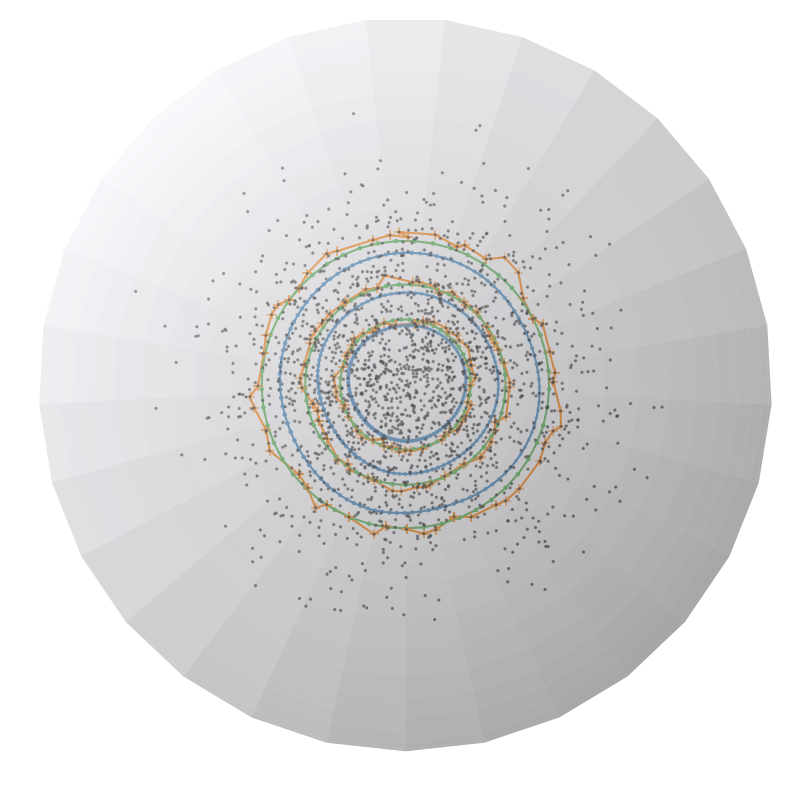

In [ ]:
plt.figure(figsize=(10,10))
ax = functions.def_ax_sphere3D(90,0,sph_alpha=0.3)
functions.plot_3d_scatter(data ,ax,colour="black",sz=2,alpha=0.5)

for i,tau in enumerate(rayons):
     # Regularized : 
     points = functions.contour_unif_rotated(F_thetaM,tau,size=100)
     df = functions.QentropicBP_pts(points,u,data,eps)
     ax.plot(df[:,0],df[:,1],df[:,2],c= '#377eb8')
     ax.scatter(df[:,0],df[:,1],df[:,2],c= '#377eb8',s=5)
     # Unregularized : 
     df = contours_dis[i]
     ax.plot(df[:,0],df[:,1],df[:,2],c= '#ff7f00')
     ax.scatter(df[:,0],df[:,1],df[:,2],c= '#ff7f00',s=50,marker="+")
     df = df[[len(df)-1,0],:]
     ax.plot(df[:,0],df[:,1],df[:,2],c= '#ff7f00')
     # Ground truth : 
     df = contours_true[i]
     ax.plot(df[:,0],df[:,1],df[:,2],c= '#4daf4a')
     ax.scatter(df[:,0],df[:,1],df[:,2],c= '#4daf4a',s=5)



# 3) MSE comparison

In [11]:
import pandas as pd
import seaborn as sns

In [16]:
def MSE(points,true_points):
    ''' 
    points and true_points must be of shape (N,3) 
    '''    
    dist_pt = 0.5*np.arccos(points[:,0]*true_points[:,0] + points[:,1]* true_points[:,1] + points[:,2]* true_points[:,2])**2
    MSE_dis = np.mean(dist_pt) 
    return(MSE_dis)

In [17]:
range_eps = np.round(np.linspace(0.01,0.2,10),2)
N = 50 
range_MSE_OT = -np.ones(N)
range_MSE_EOT = -np.ones((N,len(range_eps)))

for rep in range(N):
    n_samples = 500 
    kappa = 10
    data = Hypersphere(dim=2).random_von_mises_fisher(mu=np.array([0,0,1]),kappa=kappa, n_samples=n_samples)
    nb = n_samples
    unif = np.random.normal(size=(nb,3))
    unif = unif / np.linalg.norm(unif,axis=1).reshape(nb,1)

    # Ground truth
    Img_true = []
    for p in unif:
        phi,tht = functions.cartesian2polar(p) 
        z3 = inv_Ff_star(p[2],kappa)
        thtnew = np.arccos(z3)
        thtnew = np.pi/2 - thtnew
        p = functions.polar2cartesian(phi=phi,theta=thtnew)
        Img_true.append(p)
    Img_true = np.array(Img_true)

    # Unregularized OT
    a = np.ones(nb)/nb
    C = -np.eye(nb)
    for i in range(nb):
        for j in range(nb):
            x = unif[i]
            y = data[j]
            C[i,j] = 0.5*np.arccos( np.dot(x,y) )**2 
    T = ot.emd(a,a,C)
    Img_OT = data[np.where(T>0)[1]]
    MSE_discrete = MSE(Img_OT,Img_true)
    range_MSE_OT[rep] = MSE_discrete

    # Regularized OT
    MSE_reg = -np.ones(len(range_eps))
    for i,eps in enumerate(range_eps):
        u,hat_W = functions.Robbins_Monro_Algo(Y=data, eps=eps, gamma= 1, c = 0.51, epoch = 20,l_max=30)
        Img_EOT = functions.QentropicBP_pts(unif,u,data,eps)
        MSE_reg[i] = MSE(Img_EOT,Img_true)
    range_MSE_EOT[rep,:] = MSE_reg
    print(rep)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [18]:
a = pd.DataFrame({ 'eps' : np.repeat('0',N), 'MSE': range_MSE_OT })
med = -np.ones(len(range_eps)+1)
med[0] = np.median(range_MSE_OT)
for i,eps in enumerate(range_eps):
    b = pd.DataFrame({ 'eps' : np.repeat('{}'.format(eps),N), 'MSE': range_MSE_EOT[:,i] })
    a = pd.concat([a,b])
    med[i+1] = np.median(range_MSE_EOT[:,i])

a = a.astype('float')#.dtypes

/Users/glthurin/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/glthurin/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/glthurin/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


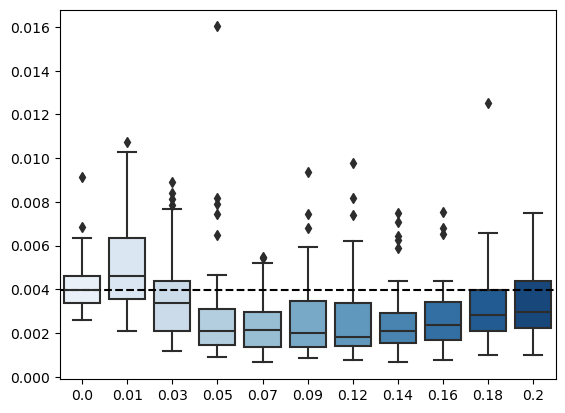

In [19]:
# Usual boxplot
bp = sns.boxplot(x='eps', y='MSE', data=a,palette="Blues")
bp.set(xlabel=None)
bp.set(ylabel=None)

left, right = plt.xlim()
bp.hlines(np.median(range_MSE_OT), left, right,color="black",linestyle="dashed")

plt.show()
